In [1]:
!pip install finance-datareader

In [2]:
import math
import pandas as pd
import numpy as np
import argparse
import FinanceDataReader as fdr

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.batchnorm import BatchNorm1d
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from copy import deepcopy
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

Populating the interactive namespace from numpy and matplotlib


# Explore Data

- Task: [Open, High, Low, Close, Vloume, Change]6개의 featrue를 이용하여 5일동안의 데이터로 그후 1, 2, 3일째의 종가 예측


In [3]:
start = "2019-01-01"
end = "2023-09-01"
df = fdr.DataReader('005930', start=start, end=end)
df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2019-01-02,39400,39400,38550,38750,7847664,0.001292
2019-01-03,38300,38550,37450,37600,12471493,-0.029677
2019-01-04,37450,37600,36850,37450,14108958,-0.003989
2019-01-07,38000,38900,37800,38750,12748997,0.034713
2019-01-08,38000,39200,37950,38100,12756554,-0.016774


<Axes: xlabel='Date'>

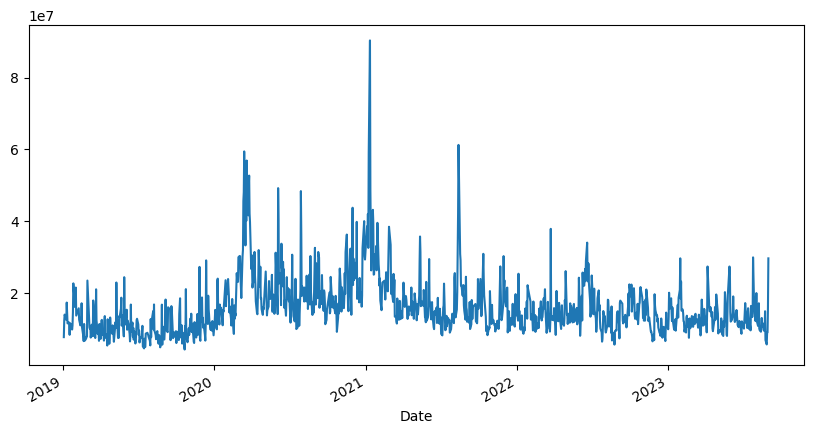

In [4]:
df.Volume.plot(figsize=(10,5))

<Axes: xlabel='Date'>

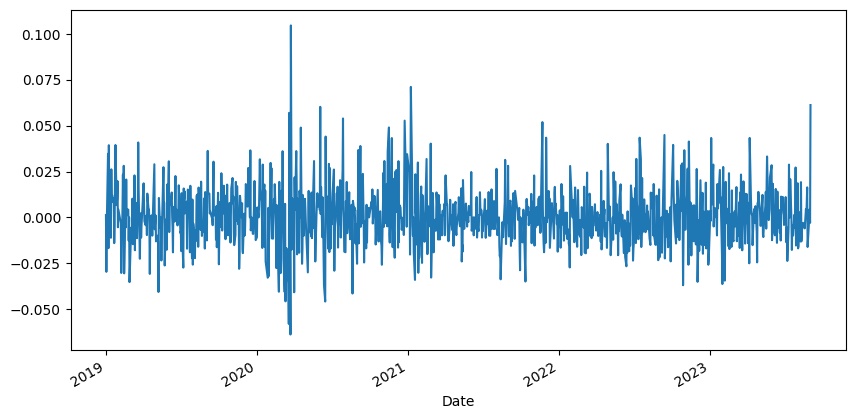

In [5]:
df.Change.plot(figsize=(10,5))

<Axes: xlabel='Date'>

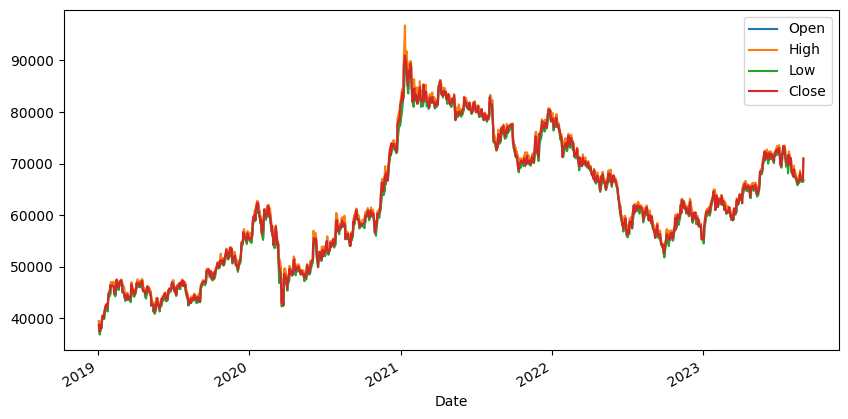

In [6]:
df.drop(["Volume", "Change"], axis=1).plot(figsize=(10,5))

# Load data & train,val,test split

- train = 2019년 1월 ~ 2021년 12월
- valid = 2022년 1월 ~ 2022년 12월
- test = 2023년 1월 ~

In [7]:
df_train = fdr.DataReader('005930', start="2019-01-01", end="2021-12-31")
df_val = fdr.DataReader('005930', start="2022-01-01", end="2022-12-31")
df_test = fdr.DataReader('005930', start="2023-01-01", end="2023-09-15")

print(df_train.isna().sum().sum())
print(df_val.isna().sum().sum())
print(df_test.isna().sum().sum())

0
0
0


# Preprocess Dataset
 - min_max scaling 이용


In [8]:
train = df_train.reset_index(drop=True)
val = df_val.reset_index(drop=True)
test = df_test.reset_index(drop=True)

scaler = MinMaxScaler()
scaler.fit(train)

train_scaled = scaler.transform(train)
val_scaled = scaler.transform(val)
test_scaled = scaler.transform(test)


# # MinMaxScaler 객체 생성
# scaler = MinMaxScaler()

# # train 데이터에 대해 스케일링을 학습
# scaler.fit(train)

# # 역변환을 원하는 컬럼 선택 (예: 'column_name')
# column_name = 'column_name'

# # train_scaled DataFrame에서 'column_name' 컬럼에 대한 역변환 수행
# train_inverse = scaler.inverse_transform(train_scaled)

# # 역변환된 데이터를 다시 DataFrame으로 변환
# train_inverse_df = pd.DataFrame(train_inverse, columns=train.columns)

# # 'column_name' 컬럼에 대한 역변환 데이터 출력
# column_inverse = train_inverse_df[column_name]

# # val_scaled, test_scaled에 대해서도 동일한 방법으로 역변환 수행 가능
# val_inverse = scaler.inverse_transform(val_scaled)
# test_inverse = scaler.inverse_transform(test_scaled)


# Pytorch Custom Dataset
Pytroch Custom Dataset을 사용하기 위해서는 아래 3개의 method만 오버라이드 해주면 된다.
 - `def __init__` 데이터셋의 전처리를 해주는 부분
 - `def __len__` 데이터셋의 길이를 반환
 - `def __getitem__`
  데이터셋에서 (특정 1개)의 샘플을 가져오는 함수

In [10]:
class StockDataset(Dataset):
    def __init__(self, data, x_window, y_window):
        self.data =  data
        self.x_window = x_window
        self.y_window = y_window

    def __len__(self):
        return len(self.data) - (self.x_window + self.y_window) + 1

    def __getitem__(self, idx):
        X = self.data[idx:idx+self.x_window, :]
        y = self.data[idx+self.x_window:idx+self.x_window+self.y_window, 3]
        return X, y

In [11]:
x_window = 5
y_window = 3
trainset = StockDataset(train_scaled, x_window, y_window)
validset = StockDataset(val_scaled, x_window, y_window)
testset = StockDataset(test_scaled, x_window, y_window)

In [37]:
train = StockDataset(train, x_window, y_window)

In [12]:
X, y = trainset.__getitem__(0)
print(X.shape)
print(y.shape)

(5, 6)
(3,)


DataLoader사용시  batch의 shape 확인

In [40]:
trainloader = DataLoader(trainset, batch_size=10, shuffle=False)
for X_batch, y_batch in trainloader:
    print(X_batch.shape) #(batch_size, x_window, x_dim)
    print(y_batch.shape) #(batch_szie, y_window)
    break

torch.Size([10, 5, 6])
torch.Size([10, 3])


In [43]:
# Lstm의 input으로 바꿔주는거
X_batch.transpose(0, 1)[0]
np.swapaxes(X_batch, 0, 1)[0]

tensor([[0.0369, 0.0304, 0.0323, 0.0243, 0.0401, 0.3866],
        [0.0161, 0.0160, 0.0114, 0.0028, 0.0939, 0.2029],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1130, 0.3552],
        [0.0104, 0.0220, 0.0180, 0.0243, 0.0971, 0.5848],
        [0.0104, 0.0270, 0.0209, 0.0121, 0.0972, 0.2794],
        [0.0227, 0.0338, 0.0275, 0.0401, 0.1519, 0.6124],
        [0.0482, 0.0431, 0.0522, 0.0439, 0.1202, 0.4089],
        [0.0549, 0.0498, 0.0589, 0.0570, 0.0845, 0.4832],
        [0.0568, 0.0524, 0.0570, 0.0486, 0.0882, 0.3130],
        [0.0492, 0.0591, 0.0570, 0.0682, 0.0825, 0.5344]], dtype=torch.float64)

In [50]:
for i in X_batch.transpose(0, 1):
    print(i.shape)

torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])
torch.Size([10, 6])


# Model Define

 - `def init_hidden()`  
 LSTM은 batch dependency한 모델이다. init_hidden()으로 인해 batch 연산에 필요한 Zero Tensor를 생성


In [14]:
input_tensor = X_batch[0]
hidden_tensor = torch.Tensor(5, 10).to(torch.double)
input_dim = 6
hidden_dim = 10

U_f = torch.Tensor(input_dim, hidden_dim).to(torch.double)
V_f = torch.Tensor(hidden_dim, hidden_dim).to(torch.double)
b_f = torch.Tensor(hidden_dim).to(torch.double)

In [16]:
ft = input_tensor@U_f + hidden_tensor@V_f + b_f

In [17]:
ft.shape

torch.Size([5, 10])

In [18]:
W_f = nn.Linear(input_dim+hidden_dim, hidden_dim, bias=True)
W_f

Linear(in_features=16, out_features=10, bias=True)

In [19]:
test = torch.cat((input_tensor, hidden_tensor), dim=1)
test = test.to(W_f.weight.dtype)
test.shape

torch.Size([5, 16])

In [20]:
W_f(test).shape

torch.Size([5, 10])

In [21]:
tensor1 = torch.tensor([1, 2, 3])
tensor2 = torch.tensor([[4, 5, 6],
                       [7, 8, 9]])

# element-wise 곱 수행
result = torch.mul(tensor2, tensor1)

In [53]:
result

tensor([[ 4, 10, 18],
        [ 7, 16, 27]])

In [52]:
result.view(-1)

tensor([ 4, 10, 18,  7, 16, 27])

In [26]:
result[:, 0]

tensor([4, 7])

In [23]:
result[-1]

tensor([ 7, 16, 27])

In [25]:
result[-1].view(3, -1)

tensor([[ 7],
        [16],
        [27]])

In [73]:
import torch.nn.init as init

In [74]:
class LSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, bias=True):
        super(LSTMCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.bias = bias

        self.forgetgate = nn.Linear(input_dim+hidden_dim, hidden_dim, bias=bias)
        self.ingate = nn.Linear(input_dim+hidden_dim, hidden_dim, bias=bias)
        self.cellgate = nn.Linear(input_dim+hidden_dim, hidden_dim, bias=bias)
        self.outgate = nn.Linear(input_dim+hidden_dim, hidden_dim, bias=bias)

        self.init_weights()

    def init_weights(self):
        std = 1.0 / math.sqrt(self.hidden_dim)
        for param in self.parameters():
            init.uniform_(param.data, -std, std)
            # w.weight.data.uniform(-std, std)

    def forward(self, x, hidden):
        h, c = hidden

        f_t = F.sigmoid(self.forgetgate(torch.cat((x, h), dim=1))) #.to(self.forgetgate.weight.dtype)
        i_t = F.sigmoid(self.ingate(torch.cat((x, h), dim=1)))
        c_t = F.tanh(self.cellgate(torch.cat((x, h), dim=1)))
        o_t = F.sigmoid(self.outgate(torch.cat((x, h), dim=1)))

        #element wise 곱 연산
        c_update = torch.mul(c, f_t)+torch.mul(i_t,c_t)
        h_update = torch.mul(o_t, F.tanh(c_update))

        return (h_update, c_update)

In [83]:
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, batch_size, dropout, use_bn=True):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.batch_size = batch_size
        self.dropout = dropout
        self.use_bn = use_bn

        self.lstm = LSTMCell(input_dim, hidden_dim)
        self.hidden = self.init_hidden()
        self.regressor = self.make_regressor()

    def init_hidden(self):
        return (torch.zeros(self.batch_size, self.hidden_dim), #h
                torch.zeros(self.batch_size, self.hidden_dim)) #c

    def make_regressor(self):
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))

        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim))
        regressor = nn.Sequential(*layers)
        return regressor

    def forward(self, x):
        self.hidden = self.lstm(x, self.hidden)
        y_pred = self.regressor(self.hidden[0]) #lstm_out[-1].view(self.batch_size, -1)
        return y_pred

# Train, Validate, Test

In [110]:
def train(model, data, optimizer, loss_fn, args):
    trainloader = DataLoader(data,
                             batch_size=args.batch_size,
                             shuffle=True, drop_last=True)
    model.train()
    model.zero_grad()
    optimizer.zero_grad()

    train_loss = 0.0
    for i, (batch_X, batch_y) in enumerate(trainloader):

        #propagation
        batch_X = batch_X.transpose(0, 1).to(torch.float32).to(args.device) #(sequence_length, batch_size, input_dim)
        for X in batch_X:
            y_pred = model(X) #마지막 output값만 필요

        model.zero_grad()
        optimizer.zero_grad()
        model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

        loss = loss_fn(y_pred.to(torch.float32).view(-1), batch_y.to(torch.float32).view(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss = train_loss / len(trainloader)
    return model, train_loss

In [122]:
def validate(model, data, loss_fn, args):
    valloader = DataLoader(data,
                           batch_size=args.batch_size,
                           shuffle=False, drop_last=True)
    model.eval()

    val_loss = 0.0
    with torch.no_grad():
        for i, (batch_X, batch_y) in enumerate(valloader):
            batch_X = batch_X.transpose(0, 1).to(torch.float32).to(args.device)
            for X in batch_X:
                y_pred = model(X)

            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            loss = loss_fn(y_pred.to(torch.float32).view(-1), batch_y.to(torch.float32).view(-1))

            val_loss += loss.item()

    val_loss = val_loss / len(valloader)
    return val_loss

In [146]:
def test(model, data, loss_fn, args):
    testloader = DataLoader(data,
                           batch_size=args.batch_size,
                           shuffle=False, drop_last=True)
    model.eval()

    test_loss = 0.0
    with torch.no_grad():
        for i, (batch_X, batch_y) in enumerate(testloader):
            batch_X = batch_X.transpose(0, 1).to(torch.float32).to(args.device)
            for X in batch_X:
                y_pred = model(X)

            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            loss = loss_fn(y_pred.to(torch.float32).view(-1), batch_y.to(torch.float32).view(-1))

            test_loss += loss.item()

    test_loss = test_loss / len(testloader)
    return test_loss


In [147]:
def experiment(data, args):

    model = LSTM(args.input_dim, args.hidden_dim, args.output_dim, args.batch_size, args.dropout, args.use_bn)
    model.to(args.device)
    loss_fn = torch.nn.MSELoss()
    optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)

    # ===== loss history ====== #
    train_losses = []
    val_losses = []
    test_losses = []
    # ===================================== #

    for epoch in range(args.epoch):
        model, train_loss = train(model, data["train"], optimizer, loss_fn, args)
        val_loss = validate(model, data["valid"], loss_fn, args)
        test_loss = test(model, data["test"], loss_fn, args)
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)
        # ============================ #

        print(f"EPOCH: {epoch} // Train Loss: {train_loss} // Valid Loss: {val_loss}")

    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['test_losses'] = test_losses

    return model, result

In [151]:
# ====== Random Seed Initialization ====== #
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ======= Make Data Dict ====== #
data = {"train": trainset, "valid": validset, "test": testset}

# ====== Model Capacity ===== #
args.input_dim = 6
args.hidden_dim = 50
args.batch_size = 50
args.output_dim = 3

# ====== Regularization ======= #
args.l2 = 0.00001
args.dropout = 0.0
args.use_bn = True

# ====== Optimizer & Training ====== #
args.lr = 0.0001
args.epoch = 100

In [152]:
model, result = experiment(data, args)

EPOCH: 0 // Train Loss: 0.31905339658260345 // Valid Loss: 0.2660878114402294
EPOCH: 1 // Train Loss: 0.2426141638840948 // Valid Loss: 0.2383832484483719
EPOCH: 2 // Train Loss: 0.20641787030867167 // Valid Loss: 0.2082642875611782
EPOCH: 3 // Train Loss: 0.17467413204056875 // Valid Loss: 0.19427499547600746
EPOCH: 4 // Train Loss: 0.15752949459212168 // Valid Loss: 0.16162822023034096
EPOCH: 5 // Train Loss: 0.1368643907564027 // Valid Loss: 0.1636359542608261
EPOCH: 6 // Train Loss: 0.1205145466540541 // Valid Loss: 0.1520320624113083
EPOCH: 7 // Train Loss: 0.10931708557265145 // Valid Loss: 0.14196455106139183
EPOCH: 8 // Train Loss: 0.0933069357914584 // Valid Loss: 0.12442437931895256
EPOCH: 9 // Train Loss: 0.08483008561389786 // Valid Loss: 0.13662872277200222
EPOCH: 10 // Train Loss: 0.07699969623770032 // Valid Loss: 0.09257370419800282
EPOCH: 11 // Train Loss: 0.0684070105531386 // Valid Loss: 0.09636453352868557
EPOCH: 12 // Train Loss: 0.06061600015631744 // Valid Loss: 

<Axes: >

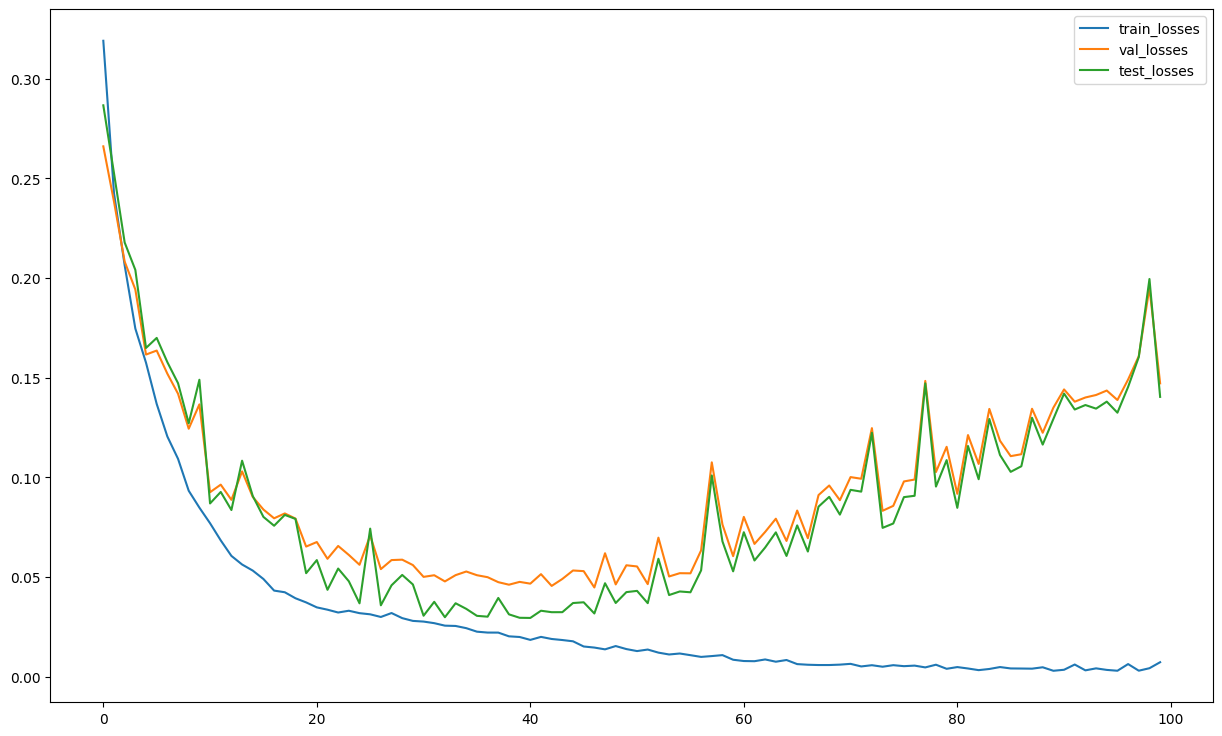

In [153]:
pd.DataFrame(result).plot()